In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
import photon_spectrum
from time import process_time
from scipy.optimize import minimize, rosen, rosen_der, root, root_scalar
import warnings
import time
warnings.filterwarnings("ignore")
from urllib.request import urlopen
import astropy.io.fits as fits
from matplotlib.colors import LogNorm
import re
import healpy as hp
import importlib

In [2]:
filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']


def nfw_profile_density(r, gamma = 1, massBH = 1.5e17):
    #need to eventually normalize to local density (4 GeV/cm^2)
    #also normalize to fraction of DM in black holes
    r_s = 20 #kpc
    #make sure r is in kpc
    rho_0 = get_rho0(massBH, gamma_forrho0 = gamma)
    rho = rho_0/(r/r_s)**(gamma)/((1+r/r_s)**(3-gamma)) #.4 GeV/cm^3
    return rho

def get_rho0(massBH = 1.5e17, gamma_forrho0 = 1):
    massBH_GeV = massBH*5.609e23 #to GeV
    #calculating the initial rho_0
    r = 8.25 #kpc
    R_s = 20 #kpc
    rho_NFW = 0.4/massBH_GeV #BHs/cm^3, should be BHs/cm^3
    rho_0 = (r/R_s)**(gamma_forrho0)*rho_NFW*(1+r/R_s)**(3-gamma_forrho0)
    #print('rho_0: {}'.format(rho_0))
    #rho_0 = .257
    return rho_0

In [3]:
def i_hate_trig(theta, l):
    R_GC = 8.25 #kpc
    theta_radians = theta/180*np.pi

    r = np.sqrt(l**2+R_GC**2-2*l*R_GC*math.cos(theta_radians))

    #B = np.arcsin(l*np.sin(theta)/r)
    #phi = 180-theta-B
    
    return r
    
    
def range_over_l(theta, massofBH = 1.5e17, gamma_here = 1):
    l = np.linspace(1, 60, 5000) #in kpc
        
    r = i_hate_trig(theta, l)
    #print(r)

    density = nfw_profile_density(r, massBH = massofBH, gamma = gamma_here)
    #print(density)

    
    return l, density

def get_deltaE(n):
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    bins_in_lin = np.log10(energybins)[n]
    spacing = 0.05691431
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return high_bin, low_bin

def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

    

In [22]:
def get_long_lat(longlatboo = True):

    filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
    hdu = fits.open(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = longlatboo)

    #all indices within 20 deg
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    #all indices within 25 deg
    ipix_disc25 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(25), inclusive = False)
    
    #the l and b values we want:
    
    testl = degrees[0][ipix_disc25]
    testb = degrees[1][ipix_disc25]
    
    #need to find the values of testl that are greater than 200 and subtract 360 from them
    
    where_large = np.argwhere(testl > 200)
    testl[where_large] = testl[where_large]-360

    return np.array(testl), np.array(testb), ipix_disc20, ipix_disc25

def get_j_factors(massBH = 1.5e17, gam = 1):

    btest, ltest, indices20, indices25 = get_long_lat()

    thetas = np.sqrt(btest**2+ltest**2)
    
    integral = []
    
    #ls are in kpc
    
    for theta in thetas:
        #get the NFW density, and the lengths
        theta = np.abs(theta)
        ls, rho = range_over_l(theta, massofBH = massBH, gamma_here = gam)
        n_BH = rho #*1e-4 #this also includes rho_0, can also use 1e-4 for PBH as DM 
        ls_incm3 = ls*3.086e21
        integral.append(np.trapz(n_BH, x = ls_incm3)) #trapezoidal rule, with n_Bh on y axis and the length on x
    integral = np.asarray(integral) #in GeV/cm^2?
    
        
    return thetas, integral, indices20, indices25 #*lum/4/np.pi #units of GeV/cm^-2? 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_dNdE(egamma_values, energy_index, gamma = 1, mass = 2e16, for_normals = False):
    #may need to integrate over this eventually
    thetas, integral, indices20, indices25 = get_j_factors(massBH = mass, gam = gamma) #in GeV/cm^-2
    
    #eventually make it so this is only calculated once per mass_bh
    lum = (photon_spectrum.get_integral(egamma_values, mass_bh = mass)[1]*1e3) #units of photons per GeV per sec per BH
    #need to integrate luminosity over energy bin
    energy_bin_min_max = get_deltaE(energy_index)
    high_idx = find_nearest(energies, energy_bin_min_max[0])
    low_idx = find_nearest(energies, energy_bin_min_max[1])

    lum_final = np.trapz(lum[low_idx:high_idx], x = energies[low_idx:high_idx]) #now in photons per sec
    
    #now we need to add the integral back into the array where it was originally
    blank_array = np.empty(196608)
    blank_array[:] = 0
    
    tempBH_ev = (1/photon_spectrum.inverseT(mass)) #mass in GeV
    #print('temp: {}'.format(tempBH_ev))
    
    count = 0
    blank_array[indices25] = integral
    #frac BH in units of % dark matter in black holes
    
    if for_normals:
        #need to only return the inner 20 degrees
        new_arr = blank_array[indices20]
        return thetas, new_arr*lum_final/tempBH_ev/4/np.pi#/5938
    
    return thetas, blank_array*lum_final/tempBH_ev/4/np.pi #units of photons per str per sec per cm^2


In [17]:
tempBH_ev = (1/photon_spectrum.inverseT(1e14)) #mass in GeV
print('temp: {}'.format(tempBH_ev))


temp: 0.106


In [7]:
energies = np.logspace(np.log10(10), np.log10(1e6), num = 1000)
#energies = np.logspace(np.log10(.027), np.log10(500), num = 1000)
egamma_values = photon_spectrum.get_egammas(energies)

In [8]:
print(len(egamma_values[0]))

1000


In [14]:
jfacs = get_j_factors(massBH = 1.5e17, gam = 1)

In [23]:
importlib.reload(photon_spectrum)
dnde = get_dNdE(egamma_values, energy_index = 0, gamma = 1.8, mass = 2e14, frac_BHs = 1)

In [91]:
print(len(egamma_values))
print(len(egamma_values[0]))

1000
38


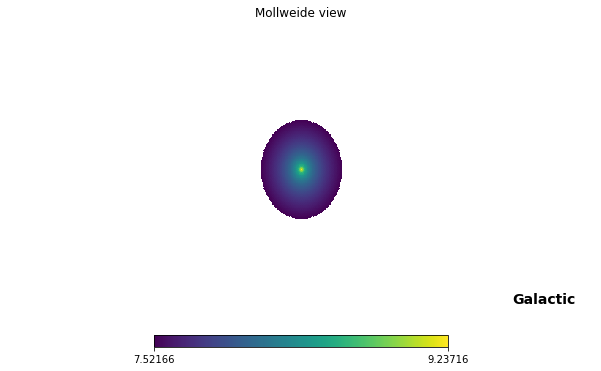

In [24]:
hp.mollview(np.log10(dnde[1]), coord = 'G')